In [9]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
import cv2
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms.functional as TF

In [10]:
# Define a mapping from grayscale values to class indices
grayscale_to_class = {
    0.: 0,
    0.5019608: 1,
    1.: 2,
}

threshold=1e-6

In [11]:
def get_train_augs():
    return A.Compose([
        # A.RandomCrop(height=128, width=128),
        A.HorizontalFlip(p=0.05),
        A.VerticalFlip(p=0.05),
        A.Rotate(limit=30, p=0.5),  # Random rotation up to 30 degrees
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.2),
        A.Blur(blur_limit=(3, 7), p=0.2),  # Random blur
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.HorizontalFlip(p=0.05)
    ], p=1.0)

def get_valid_augs():
    return A.Compose([
        # A.Resize(512, 512),
    ], p=1.0)


In [36]:
import logging
# import os

# # Set up logging
# log_dir = "logs"
# os.makedirs(log_dir, exist_ok=True)
# log_file = os.path.join(log_dir, "training_log.txt")
# logging.basicConfig(filename=log_file, level=logging.INFO, format="%(asctime)s [%(levelname)s]: %(message)s")

logging.basicConfig(filename='training_log.txt', level=logging.INFO)



In [65]:
class RAVIRDataset(Dataset):
    def __init__(self, root, train, augmentations=None, augmentation_times=8, target_size=(512, 512)):
        self.root = root
        self.train = train
        self.target_size = target_size
        self.augmentations = augmentations
        self.augmentation_times = augmentation_times if train else 1

        self.images = list(sorted(os.listdir(os.path.join(root, "training_images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "training_masks"))))

        # Split data into train and test sets
        self.images_train, self.images_test, self.masks_train, self.masks_test = train_test_split(
            self.images, self.masks, test_size=0.2, random_state=42)

    def __len__(self):
        if self.train:
            return len(self.images_train) * self.augmentation_times
        else:
            return len(self.images_test)

    def __getitem__(self, idx):
        # Adjust index for augmented samples
        original_idx = idx // self.augmentation_times

        if self.train:
            imagePath = os.path.join(self.root, "training_images/", self.images_train[original_idx])
            maskPath = os.path.join(self.root, "training_masks", self.masks_train[original_idx])
        else:
            imagePath = os.path.join(self.root, "training_images", self.images_test[original_idx])
            maskPath = os.path.join(self.root, "training_masks", self.masks_test[original_idx])

        # Load image and mask
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0  # Convert to float and normalize
        mask = cv2.imread(maskPath, cv2.IMREAD_GRAYSCALE)
        mask = mask.astype(np.float32)
        # mask = mask.astype(np.float32) / 255.0  # Convert to float and normalize

#         # Resize the image and mask to the target size
#         image = cv2.resize(image,self.target_size, cv2.INTER_LINEAR)
#         mask = cv2.resize(mask,self.target_size, cv2.INTER_NEAREST)

        # Apply augmentations
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = np.transpose(image, (2, 0, 1))
        mask = mask.reshape((mask.shape[0],mask.shape[1],1))/255.0

        # Map the grayscale values to class indices
        mask_indices = torch.zeros(mask.shape, dtype=torch.long)
        for grayscale, class_index in grayscale_to_class.items():
            mask_indices[(mask > grayscale - threshold) & (mask <= grayscale + threshold)] = class_index
            mask_indices = mask_indices.long()
        mask = np.transpose(mask, (2, 0, 1))
        mask_indices = np.transpose(mask_indices, (2, 0, 1))

        return image, mask_indices

In [66]:
BATCH_SIZE = 2
root = "/kaggle/input/ravir-dataset/train"

In [67]:
mask = Image.open("/kaggle/input/ravir-dataset/train/training_images/IR_Case_011.png").convert("L")
mask.size

(768, 768)

In [68]:
trainDataset = RAVIRDataset(root,train = True,augmentations = get_train_augs())
testDataset = RAVIRDataset(root,train = False,augmentations = get_valid_augs())

In [69]:
trainDataLoader = DataLoader(trainDataset , batch_size =BATCH_SIZE , shuffle =True )
testDataLoader = DataLoader(testDataset , batch_size =BATCH_SIZE  )

In [70]:
# # Split the dataset into train and validation
# train_size = int(0.85 * len(trainDataset))
# val_size = len(trainDataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(trainDataset, [train_size, val_size])

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [71]:
# Assuming 'train_loader' is your DataLoader
num_images = len(trainDataLoader.dataset)  # total number of images in the dataset
batch_size = trainDataLoader.batch_size  # batch size used in the DataLoader

total_images = num_images * batch_size
print(f"Total number of images in the DataLoader: {total_images}")


Total number of images in the DataLoader: 288


In [72]:

# Function to convert torch tensor to numpy array and denormalize
def tensor_to_numpy(tensor):
    return tensor.cpu().detach().numpy()

# Function to plot images, masks, and predictions
def plot(images, masks):
    num_samples = len(images)

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(tensor_to_numpy(images[i]).transpose(1, 2, 0), cmap='gray')
        plt.title('Image')

        plt.subplot(1, 3, 2)
        plt.imshow(tensor_to_numpy(masks[i]).transpose(1, 2, 0), cmap='gray')
        plt.title('Ground Truth Mask')

        plt.show()


  0%|          | 0/72 [00:00<?, ?it/s]

torch.Size([2, 3, 768, 768])
torch.Size([2, 1, 768, 768])


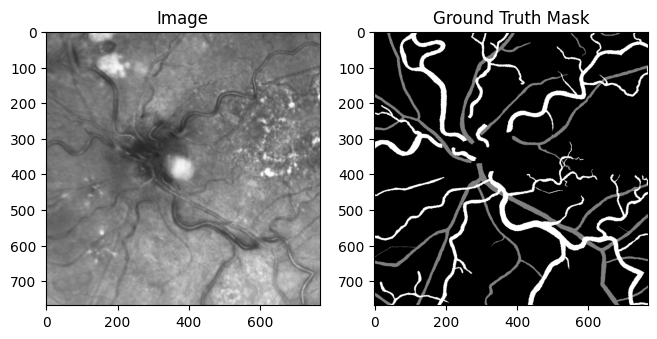

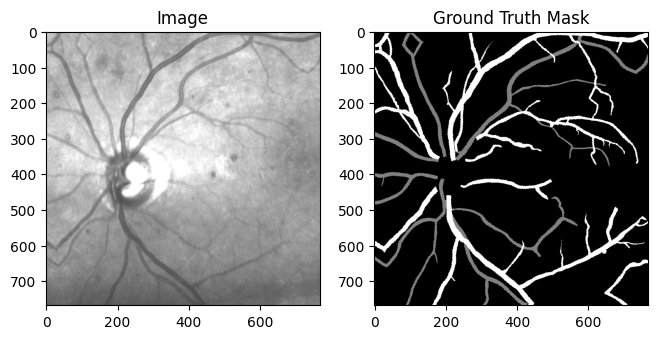

  0%|          | 0/72 [00:01<?, ?it/s]


In [73]:
for image,mask in tqdm(trainDataLoader):
  print(image.shape)
  print(mask.shape)
  plot(image,mask)

  break

In [22]:
len(trainDataset)


144

In [23]:
len(testDataset)


5

Images shape:  torch.Size([3, 512, 512])
masks shape:  torch.Size([1, 512, 512])


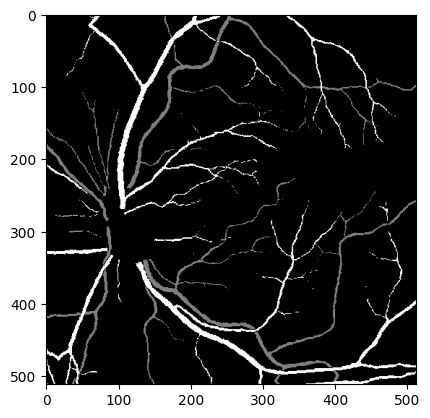

In [24]:
# Get a batch of training data
images, masks = next(iter(trainDataLoader))
print("Images shape: ", images[0].shape)
print("masks shape: ", masks[0].shape)

plt.imshow(masks[0].squeeze().cpu().numpy(), cmap='gray')

In [25]:
# # Get a batch of training data
# images, masks = next(iter(trainDataLoader))
# print("Images shape: ", images[0].shape)
# print("masks shape: ", masks[0].shape)

# # Function to show images and masks
# def show_images(images, masks, num_images=4):
#     fig, axs = plt.subplots(2, num_images, figsize=(15, 5))
#     for i in range(num_images):
#         axs[0, i].imshow(images[i].permute(1, 2, 0))
#         axs[1, i].imshow(masks[i].permute(1,2,0).cpu().numpy(), cmap='gray')
#         axs[0, i].axis('off')
#         axs[1, i].axis('off')
#     plt.show()

# # Show the images and masks
# show_images(images, masks)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        #self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class RetinaSegmentor(nn.Module):
    def __init__(self):
        super(YourNetwork, self).__init__()
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # Downsampling layers
        self.layer1 = self._make_layer(16, 32, stride=2)
        self.layer2 = self._make_layer(32, 64, stride=2)
        self.layer3 = self._make_layer(64, 128, stride=2)
        self.layer4 = self._make_layer(128, 256, stride=2)

        # Upsampling layers
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.layer5 = self._make_layer(128, 128, stride=1)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.layer6 = self._make_layer(64, 64, stride=1)
        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.layer7 = self._make_layer(32, 32, stride=1)
        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.layer8 = self._make_layer(16, 16, stride=1)
        self.layer9 = self._make_layer(16, 16, stride=1)


        # Output layer
        self.conv2 = nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)

    def _make_layer(self, in_channels, out_channels, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        return ResidualBlock(in_channels, out_channels, stride, downsample)

    def forward(self, x):
        # Initial convolutional layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Store the outputs for skip connections
        identity1 = x

        # Downsample
        x = self.layer1(x)
        identity2 = x
        x = self.layer2(x)
        identity3 = x
        x = self.layer3(x)
        identity4 = x
        x = self.layer4(x)

        # Upsample and add skip connections
        x = self.upconv1(x) + identity4
        x = self.layer5(x)
        x = self.upconv2(x) + identity3
        x = self.layer6(x)
        x = self.upconv3(x) + identity2
        x = self.layer7(x)
        x = self.upconv4(x) + identity1
        #x = self.layer8(x)

        # # New layers (Conv2d - Conv2d - Softmax)
        # x = F.relu(x)
        # x = self.conv3(x)
        # x = F.relu(x)
        # x = self.conv2(x)
        # output = F.softmax(x, dim=1)

        # return output

        # Output layer

        x = self.layer9(x)

        x = self.conv2(x)
        output = F.softmax(x, dim=1)

        return output
# Instantiate the model
net = RetinaSegmentor()
x
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)


In [77]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True)
#scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
num_epochs = 100

In [78]:
# optimizer = optim.Adam(net.parameters(), lr=0.005)
# num_epochs = 50

In [79]:
def train_one_epoch(model, train_loader, optimizer, loss_criterion, device):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc="Training", leave=False):
        torch.cuda.empty_cache()
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.squeeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        # outputs = torch.argmax(outputs, dim=1)

        loss = loss_criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    logging.info(f"Epoch {epoch}, Train Loss: {avg_loss:.4f}")
    return avg_loss

def validate(model, val_loader, loss_criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        torch.cuda.empty_cache()
        for images, masks in tqdm(val_loader, desc="Validation", leave=False):
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.squeeze(1)

            outputs = model(images)
            # outputs = torch.argmax(outputs, dim=1)

            loss = loss_criterion(outputs, masks)

            running_loss += loss.item()

    avg_loss = running_loss / len(val_loader)
    logging.info(f"Epoch {epoch}, Validation Loss: {avg_loss:.4f}")
    return avg_loss

In [80]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [81]:
# Initialize the Dice Loss function
#loss_criterion = DiceLoss()

loss_criterion=nn.CrossEntropyLoss()


In [119]:
model = net

# Step 2: Load Pre-trained Weights
pretrained_weights_path = "/kaggle/working/model_weights_V12_0.71_0.85_768*768.pth"
pretrained_dict = torch.load(pretrained_weights_path)
model.load_state_dict(pretrained_dict)
model.eval()

YourNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (r

Epoch [1/100], Train Loss: 0.7009, Val Loss: 0.6674


Epoch [2/100], Train Loss: 0.6458, Val Loss: 0.6628


Epoch [3/100], Train Loss: 0.6389, Val Loss: 0.6435


Epoch [4/100], Train Loss: 0.6335, Val Loss: 0.6556


Epoch [5/100], Train Loss: 0.6287, Val Loss: 0.6262


Epoch [6/100], Train Loss: 0.6248, Val Loss: 0.6360


Epoch [7/100], Train Loss: 0.6221, Val Loss: 0.6322


Epoch [8/100], Train Loss: 0.6195, Val Loss: 0.6294


Epoch [9/100], Train Loss: 0.6165, Val Loss: 0.6251


Epoch [10/100], Train Loss: 0.6161, Val Loss: 0.6263


Epoch [11/100], Train Loss: 0.6147, Val Loss: 0.6231


Epoch [12/100], Train Loss: 0.6135, Val Loss: 0.6178


Epoch [13/100], Train Loss: 0.6114, Val Loss: 0.6176


Epoch [14/100], Train Loss: 0.6084, Val Loss: 0.6224


Epoch [15/100], Train Loss: 0.6080, Val Loss: 0.6146


Epoch [16/100], Train Loss: 0.6077, Val Loss: 0.6139


Epoch [17/100], Train Loss: 0.6058, Val Loss: 0.6163


Epoch [18/100], Train Loss: 0.6063, Val Loss: 0.6157


Epoch [19/100], Train Loss: 0.6059, Val Loss: 0.6238


Epoch [20/100], Train Loss: 0.6036, Val Loss: 0.6126


Epoch [21/100], Train Loss: 0.6032, Val Loss: 0.6139


Epoch [22/100], Train Loss: 0.6020, Val Loss: 0.6115


Epoch [23/100], Train Loss: 0.6023, Val Loss: 0.6123


Epoch [24/100], Train Loss: 0.6008, Val Loss: 0.6112


Epoch [25/100], Train Loss: 0.5990, Val Loss: 0.6113


Epoch [26/100], Train Loss: 0.6009, Val Loss: 0.6123


Epoch [27/100], Train Loss: 0.6009, Val Loss: 0.6123


Epoch [28/100], Train Loss: 0.5974, Val Loss: 0.6112


Epoch [29/100], Train Loss: 0.5986, Val Loss: 0.6071


Epoch [30/100], Train Loss: 0.5979, Val Loss: 0.6077


Epoch [31/100], Train Loss: 0.5970, Val Loss: 0.6091


Epoch [32/100], Train Loss: 0.5969, Val Loss: 0.6125


Epoch [33/100], Train Loss: 0.5977, Val Loss: 0.6120


Epoch [34/100], Train Loss: 0.5969, Val Loss: 0.6089


Epoch [35/100], Train Loss: 0.5953, Val Loss: 0.6083


Epoch [36/100], Train Loss: 0.5955, Val Loss: 0.6091


Epoch [37/100], Train Loss: 0.5940, Val Loss: 0.6078


Epoch [38/100], Train Loss: 0.5956, Val Loss: 0.6092


Epoch [39/100], Train Loss: 0.5933, Val Loss: 0.6074


Epoch 00040: reducing learning rate of group 0 to 1.0000e-04.
Epoch [40/100], Train Loss: 0.5929, Val Loss: 0.6081


Epoch [41/100], Train Loss: 0.5922, Val Loss: 0.6048


Epoch [42/100], Train Loss: 0.5902, Val Loss: 0.6048


Epoch [43/100], Train Loss: 0.5896, Val Loss: 0.6049


Epoch [44/100], Train Loss: 0.5905, Val Loss: 0.6047


Epoch [45/100], Train Loss: 0.5901, Val Loss: 0.6047


Epoch [46/100], Train Loss: 0.5896, Val Loss: 0.6044


Epoch [47/100], Train Loss: 0.5903, Val Loss: 0.6046


Epoch [48/100], Train Loss: 0.5889, Val Loss: 0.6051


Epoch [49/100], Train Loss: 0.5904, Val Loss: 0.6047


Epoch [50/100], Train Loss: 0.5882, Val Loss: 0.6044


Epoch [51/100], Train Loss: 0.5891, Val Loss: 0.6050


Epoch [52/100], Train Loss: 0.5907, Val Loss: 0.6050


Epoch [53/100], Train Loss: 0.5895, Val Loss: 0.6050


Epoch [54/100], Train Loss: 0.5889, Val Loss: 0.6046


Epoch [55/100], Train Loss: 0.5884, Val Loss: 0.6050


Epoch [56/100], Train Loss: 0.5899, Val Loss: 0.6049


Epoch 00057: reducing learning rate of group 0 to 1.0000e-05.
Epoch [57/100], Train Loss: 0.5889, Val Loss: 0.6049


Epoch [58/100], Train Loss: 0.5888, Val Loss: 0.6050


Epoch [59/100], Train Loss: 0.5890, Val Loss: 0.6048


Epoch [60/100], Train Loss: 0.5880, Val Loss: 0.6047


Epoch [61/100], Train Loss: 0.5881, Val Loss: 0.6043


Epoch [62/100], Train Loss: 0.5891, Val Loss: 0.6047


Epoch [63/100], Train Loss: 0.5888, Val Loss: 0.6047


Epoch [64/100], Train Loss: 0.5874, Val Loss: 0.6046


Epoch [65/100], Train Loss: 0.5881, Val Loss: 0.6048


Epoch [66/100], Train Loss: 0.5884, Val Loss: 0.6049


Epoch [67/100], Train Loss: 0.5877, Val Loss: 0.6046


Epoch [68/100], Train Loss: 0.5876, Val Loss: 0.6047


Epoch [69/100], Train Loss: 0.5882, Val Loss: 0.6050


Epoch [70/100], Train Loss: 0.5880, Val Loss: 0.6046


Epoch [71/100], Train Loss: 0.5885, Val Loss: 0.6045


Epoch 00072: reducing learning rate of group 0 to 1.0000e-06.
Epoch [72/100], Train Loss: 0.5878, Val Loss: 0.6046


Epoch [73/100], Train Loss: 0.5901, Val Loss: 0.6045


Epoch [74/100], Train Loss: 0.5880, Val Loss: 0.6051


Epoch [75/100], Train Loss: 0.5872, Val Loss: 0.6044


Epoch [76/100], Train Loss: 0.5884, Val Loss: 0.6046


Epoch [77/100], Train Loss: 0.5873, Val Loss: 0.6050


Epoch [78/100], Train Loss: 0.5877, Val Loss: 0.6055


Epoch [79/100], Train Loss: 0.5882, Val Loss: 0.6049


Epoch [80/100], Train Loss: 0.5870, Val Loss: 0.6046


Epoch [81/100], Train Loss: 0.5892, Val Loss: 0.6049


Epoch [82/100], Train Loss: 0.5880, Val Loss: 0.6045


Epoch 00083: reducing learning rate of group 0 to 1.0000e-07.
Epoch [83/100], Train Loss: 0.5882, Val Loss: 0.6048


Epoch [84/100], Train Loss: 0.5884, Val Loss: 0.6050


Epoch [85/100], Train Loss: 0.5889, Val Loss: 0.6044


Epoch [86/100], Train Loss: 0.5883, Val Loss: 0.6048


Epoch [87/100], Train Loss: 0.5886, Val Loss: 0.6047


Epoch [88/100], Train Loss: 0.5886, Val Loss: 0.6050


Epoch [89/100], Train Loss: 0.5902, Val Loss: 0.6050


Epoch [90/100], Train Loss: 0.5894, Val Loss: 0.6045


Epoch [91/100], Train Loss: 0.5883, Val Loss: 0.6051


Epoch [92/100], Train Loss: 0.5882, Val Loss: 0.6052


Epoch [93/100], Train Loss: 0.5889, Val Loss: 0.6046


Epoch 00094: reducing learning rate of group 0 to 1.0000e-08.
Epoch [94/100], Train Loss: 0.5898, Val Loss: 0.6047


Epoch [95/100], Train Loss: 0.5888, Val Loss: 0.6044


Epoch [96/100], Train Loss: 0.5889, Val Loss: 0.6047


Epoch [97/100], Train Loss: 0.5886, Val Loss: 0.6050


Epoch [98/100], Train Loss: 0.5879, Val Loss: 0.6052


Epoch [99/100], Train Loss: 0.5887, Val Loss: 0.6044


Epoch [100/100], Train Loss: 0.5882, Val Loss: 0.6045


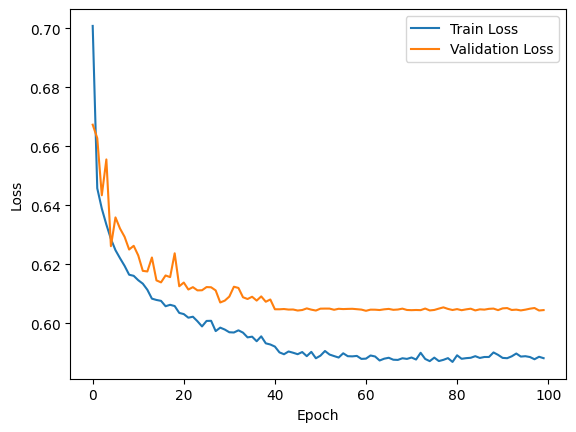

In [82]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    train_loss = train_one_epoch(net, trainDataLoader, optimizer, loss_criterion, device)
    val_loss = validate(net, testDataLoader, loss_criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
!ls /kaggle/working/logs

In [83]:
def calculate_miou(model, val_loader, device, n_classes=3):
    model.eval()
    class_iou = torch.zeros(n_classes,  device=device)  # To store IoU for each class
    class_counts = torch.zeros(n_classes,  device=device)  # To count the number of instances for each class

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Calculating mIoU", leave=False):
            images = images.to(device)
            masks = masks.to(device).squeeze(1)  # Squeeze the masks
            outputs = model(images)
            outputs = torch.argmax(outputs, dim=1)  # Convert to predicted class indices

            # Calculate IoU for each class
            for class_idx in range(n_classes):
                true_class = masks == class_idx
                pred_class = outputs == class_idx
                intersection = torch.logical_and(true_class, pred_class).sum(dim=[1, 2])
                union = torch.logical_or(true_class, pred_class).sum(dim=[1, 2])
                iou = intersection / (union + 1e-6)  # Add a small value to avoid division by zero
                valid = union > 0  # Only consider this class if it's present in ground truth or prediction

                class_iou[class_idx] += iou[valid].sum()
                class_counts[class_idx] += valid.sum()

    # Calculate mean IoU
    mIoU = (class_iou / (class_counts + 1e-6)).mean()  # Average over all classes
    return mIoU.item()

In [84]:
import torch

def calculate_dice(model, val_loader, device, n_classes=3):
    model.eval()
    class_dice = torch.zeros(n_classes, device=device)  # To store Dice coefficient for each class
    class_counts = torch.zeros(n_classes, device=device)  # To count the number of instances for each class

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Calculating Dice", leave=False):
            images = images.to(device)
            masks = masks.to(device).squeeze(1)  # Squeeze the masks
            outputs = model(images)
            outputs = torch.argmax(outputs, dim=1)  # Convert to predicted class indices

            # Calculate Dice coefficient for each class
            for class_idx in range(n_classes):
                true_class = masks == class_idx
                pred_class = outputs == class_idx
                intersection = torch.logical_and(true_class, pred_class).sum(dim=[1, 2])
                dice = 2 * intersection / (true_class.sum(dim=[1, 2]) + pred_class.sum(dim=[1, 2]) + 1e-6)  # Add a small value to avoid division by zero
                valid = true_class.sum(dim=[1, 2]) + pred_class.sum(dim=[1, 2]) > 0  # Only consider this class if it's present in ground truth or prediction

                class_dice[class_idx] += dice[valid].sum()
                class_counts[class_idx] += valid.sum()

    # Calculate mean Dice coefficient
    mean_dice = (class_dice / (class_counts + 1e-6)).mean()  # Average over all classes
    return mean_dice.item()


In [120]:
train_dice = calculate_dice(model, testDataLoader, device)
train_dice

0.8156809210777283

In [122]:
train_miou = calculate_miou(model, testDataLoader, device)
train_miou

0.7101190090179443

In [92]:
def map_classes_to_grayscale(mask, class_to_grayscale):
    mask_vis = torch.zeros_like(mask, dtype=torch.float32)

    for class_index, grayscale_value in class_to_grayscale.items():
        mask_vis = torch.where(mask == class_index, grayscale_value, mask_vis)

    # Move the tensor to CPU before converting to NumPy array
    return mask_vis.cpu().numpy()

In [93]:
def deploy_and_visualize(model, val_loader, device, num_images=4, class_to_grayscale=None):
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Deploying and Visualizing", leave=False):
            images = images.to(device)
            masks = masks.to(device).squeeze(1)

            predictions = model(images)
            predictions = torch.argmax(predictions, dim=1)
            print("predictions: ", np.unique(predictions.cpu().numpy()))

            images_np = images.cpu().numpy().transpose(0, 2, 3, 1)

            for i in range(min(num_images, images.size(0))):
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(images_np[i])
                plt.title('Input Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                if class_to_grayscale:
                    mask_vis = map_classes_to_grayscale(masks[i], class_to_grayscale)
                else:
                    mask_vis = masks[i].cpu().numpy()
                mask_vis = (mask_vis * 255).astype(np.uint8)
                plt.imshow(mask_vis, cmap='gray')
                plt.title('Ground Truth Mask')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                if class_to_grayscale:
                    pred_vis = map_classes_to_grayscale(predictions[i], class_to_grayscale)
                else:
                    pred_vis = predictions[i].cpu().numpy()
                pred_vis = (pred_vis * 255).astype(np.uint8)

                unique_values = np.unique(pred_vis)
                print("Unique values in the predicted mask after mapping:", unique_values)

                plt.imshow(pred_vis, cmap='gray')
                plt.title('Predicted Mask')
                plt.axis('off')

                plt.show()

Deploying and Visualizing:   0%|          | 0/3 [00:00<?, ?it/s]

predictions:  [0 1 2]
Unique values in the predicted mask after mapping: [  0 128 255]


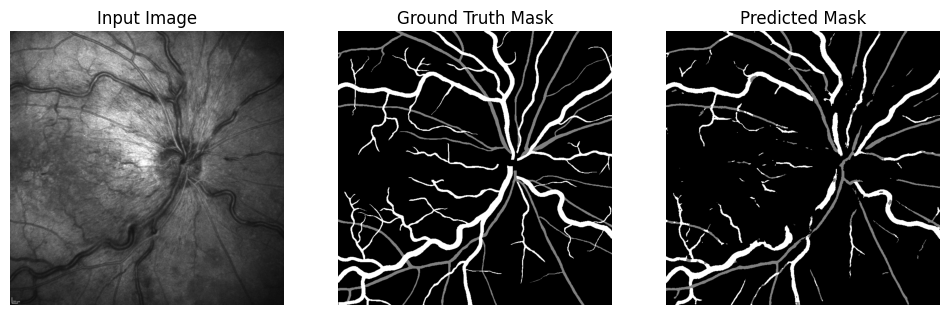

Unique values in the predicted mask after mapping: [  0 128 255]


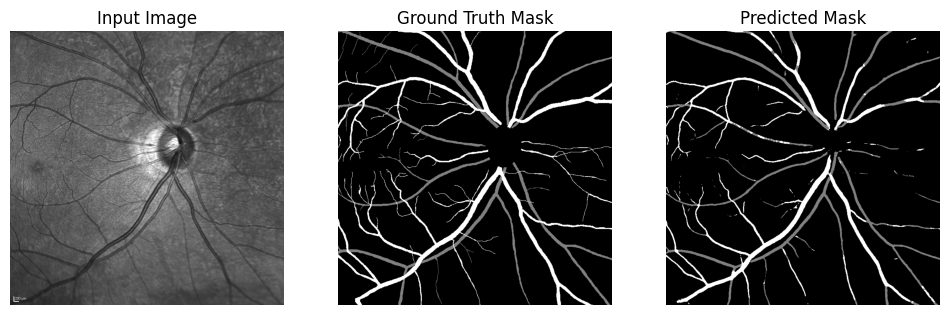

Deploying and Visualizing:  33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

predictions:  [0 1 2]
Unique values in the predicted mask after mapping: [  0 128 255]


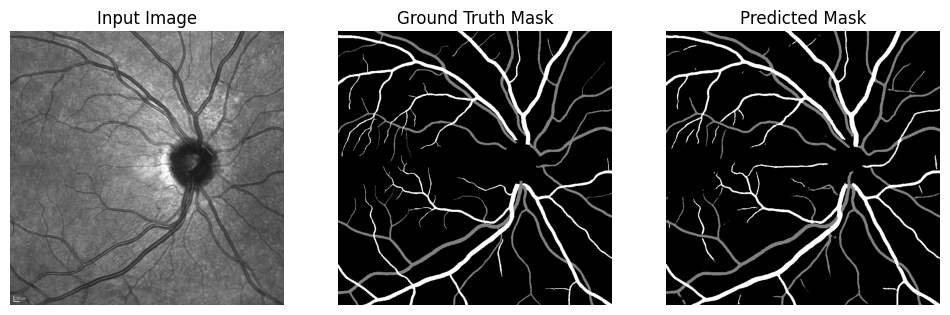

Unique values in the predicted mask after mapping: [  0 128 255]


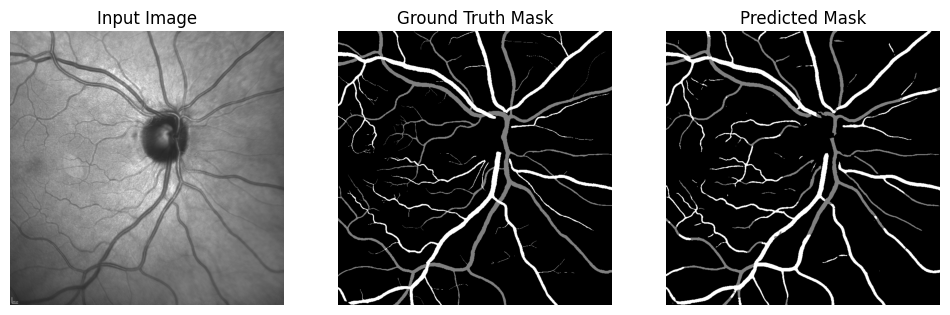

Deploying and Visualizing:  67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

predictions:  [0 1 2]
Unique values in the predicted mask after mapping: [  0 128 255]


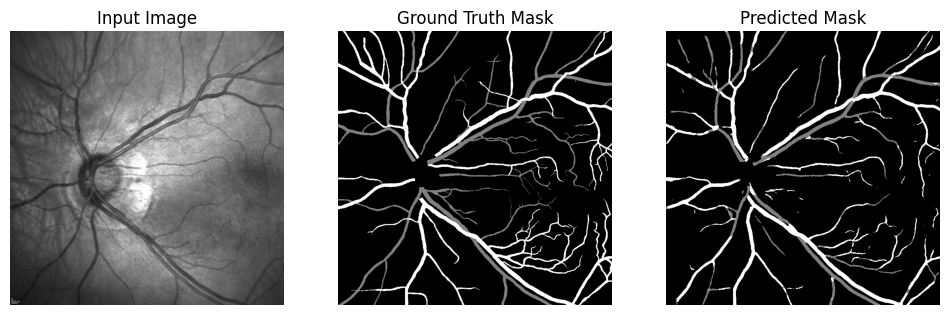

In [94]:
# Define the mapping from class indices to grayscale values
class_to_grayscale = {
    0: 0.0,        # Background
    1: 0.5019608,  # Artery
    2: 1.0         # Veins
}

deploy_and_visualize(net, testDataLoader, device, num_images=4, class_to_grayscale = class_to_grayscale)

In [95]:
# Define the directory containing test images
test_dir = '/kaggle/input/ravir-dataset/test'

# Create a list of test image file names
test_images = os.listdir(test_dir)

# Define a transform to preprocess the images (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [99]:
# Set the directory to save the images
save_dir = "/kaggle/working/test_results"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

Unique values in the predicted mask after mapping: [  0 128 255]


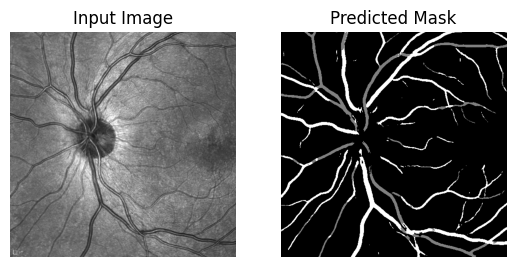

Unique values in the predicted mask after mapping: [  0 128 255]


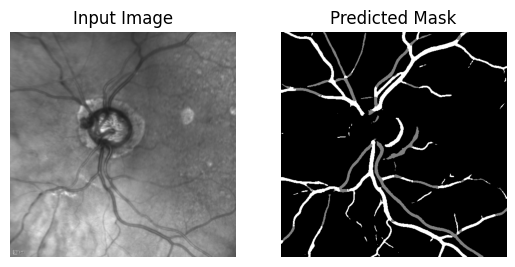

Unique values in the predicted mask after mapping: [  0 128 255]


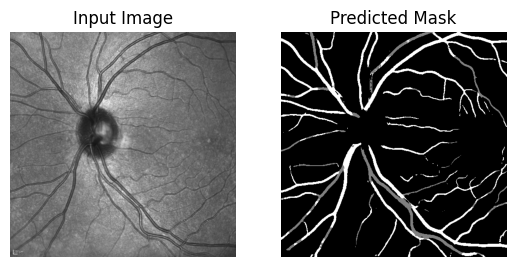

Unique values in the predicted mask after mapping: [  0 128 255]


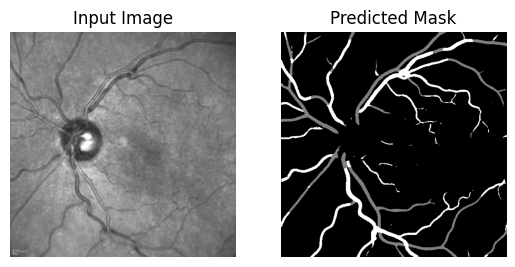

Unique values in the predicted mask after mapping: [  0 128 255]


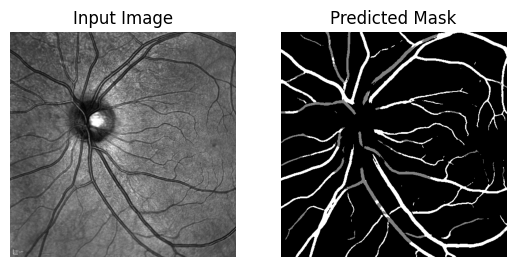

Unique values in the predicted mask after mapping: [  0 128 255]


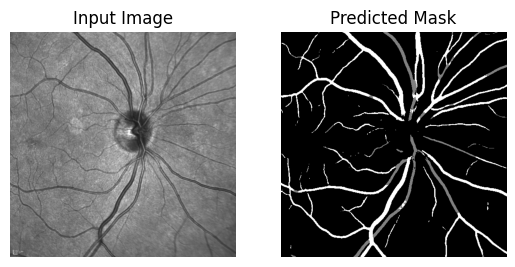

Unique values in the predicted mask after mapping: [  0 128 255]


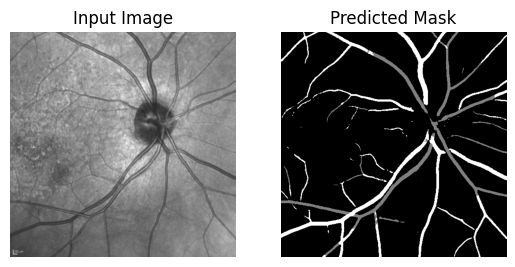

Unique values in the predicted mask after mapping: [  0 128 255]


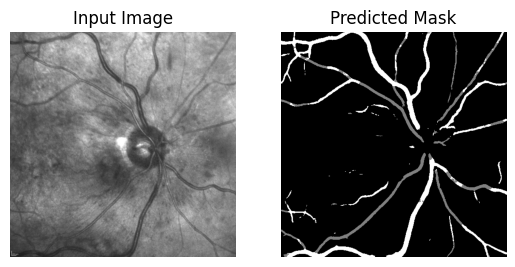

Unique values in the predicted mask after mapping: [  0 128 255]


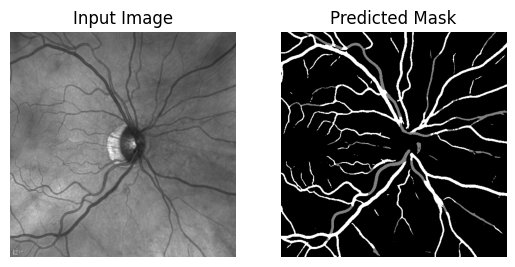

Unique values in the predicted mask after mapping: [  0 128 255]


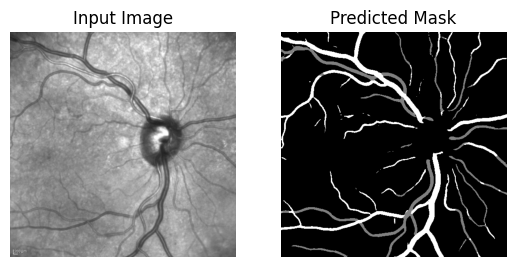

Unique values in the predicted mask after mapping: [  0 128 255]


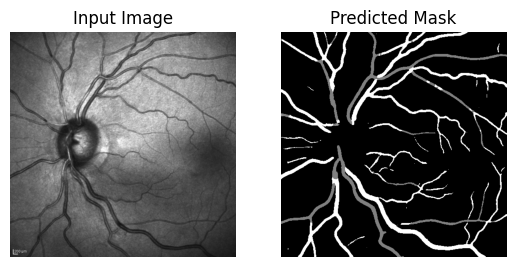

Unique values in the predicted mask after mapping: [  0 128 255]


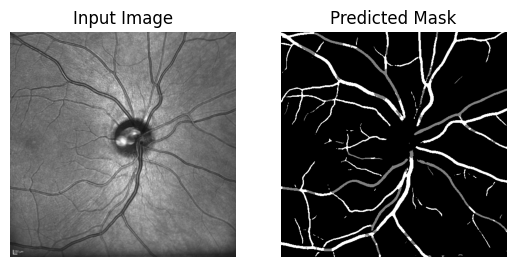

Unique values in the predicted mask after mapping: [  0 128 255]


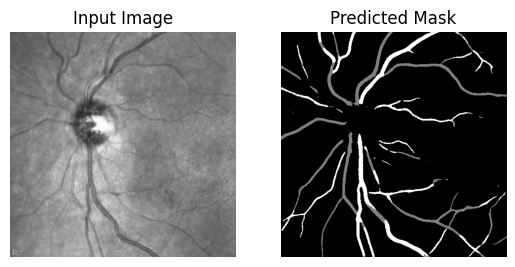

Unique values in the predicted mask after mapping: [  0 128 255]


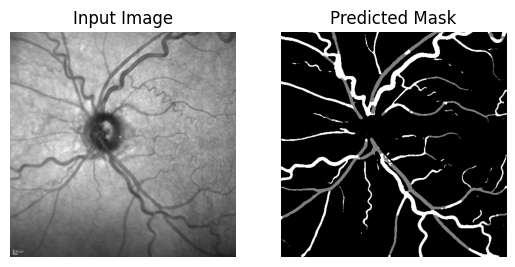

Unique values in the predicted mask after mapping: [  0 128 255]


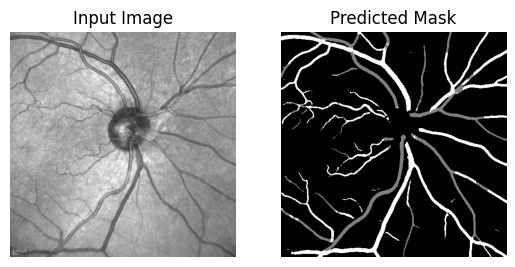

Unique values in the predicted mask after mapping: [  0 128 255]


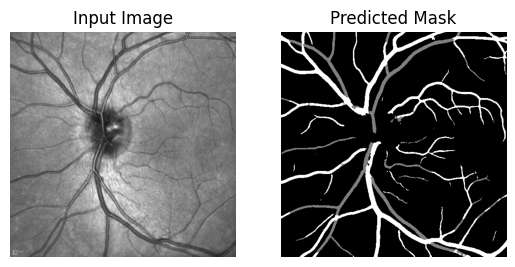

Unique values in the predicted mask after mapping: [  0 128 255]


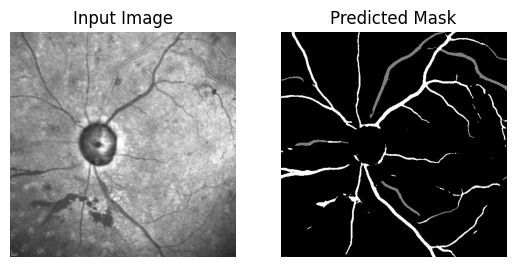

Unique values in the predicted mask after mapping: [  0 128 255]


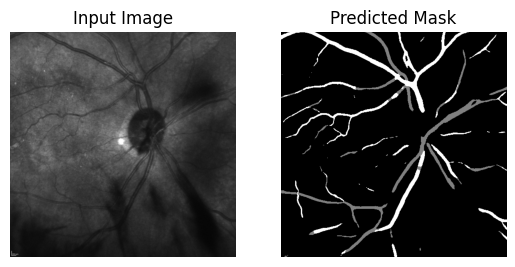

Unique values in the predicted mask after mapping: [  0 128 255]


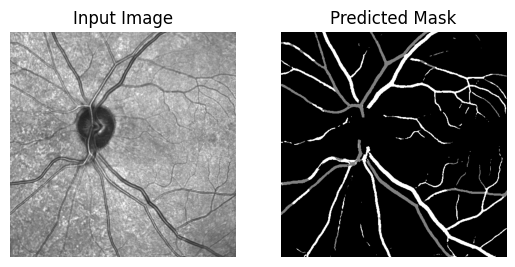

In [100]:
net.eval()

# Loop through test images, make predictions, and plot the results
for image_name in test_images:
    # Load the test image
    image_path = os.path.join(test_dir, image_name)
    image = Image.open(image_path).convert("RGB")

    # Preprocess the image
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Make predictions
    with torch.no_grad():
        predictions = net(image.to(device))  # Assuming you have a GPU, so send the image to the device

    predictions = torch.argmax(predictions, dim=1)
    # predictions = torch.argmax(predictions, dim=1).squeeze().cpu().numpy()

    # Plot
    image_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    pred_vis = map_classes_to_grayscale(predictions, class_to_grayscale)
    pred_vis = (pred_vis * 255).astype(np.uint8)

    unique_values = np.unique(pred_vis)
    print("Unique values in the predicted mask after mapping:", unique_values)

    plt.imshow(pred_vis.squeeze(0), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    # Save the figure
    save_path = os.path.join(save_dir, image_name.replace(".jpg", ".png"))
    plt.savefig(save_path)
    

    plt.show()
    

In [97]:
import logging

# Define the path where you want to save the model weights
save_path = 'model_weights_V12_0.71_0.85_768*768.pth'

# Save the model weights to the specified path
torch.save(net.state_dict(), save_path)


#logging.basicConfig(filename='training_log.txt', level=logging.INFO)


In [ ]:
logging.basicConfig(filename='training_log.txt', level=logging.INFO)



In [103]:
!zip -r /kaggle/working/test_results.zip /kaggle/working


updating: kaggle/working/ (stored 0%)
  adding: kaggle/working/test_results/ (stored 0%)
  adding: kaggle/working/test_results/IR_Case_024.png (deflated 7%)
  adding: kaggle/working/test_results/IR_Case_046.png (deflated 6%)
  adding: kaggle/working/test_results/IR_Case_042.png (deflated 6%)
  adding: kaggle/working/test_results/IR_Case_057.png (deflated 6%)
  adding: kaggle/working/test_results/IR_Case_050.png (deflated 7%)
  adding: kaggle/working/test_results/IR_Case_030.png (deflated 7%)
  adding: kaggle/working/test_results/IR_Case_054.png (deflated 7%)
  adding: kaggle/working/test_results/IR_Case_025.png (deflated 7%)
  adding: kaggle/working/test_results/IR_Case_033.png (deflated 7%)
  adding: kaggle/working/test_results/IR_Case_045.png (deflated 7%)
  adding: kaggle/working/test_results/IR_Case_031.png (deflated 8%)
  adding: kaggle/working/test_results/IR_Case_006.png (deflated 8%)
  adding: kaggle/working/test_results/IR_Case_032.png (deflated 7%)
  adding: kaggle/working/te